# Failure type classification 

This is a POC notebook for analyzing testgrids and generating a report that will identify the tests and dates where 4 different types of failures may have occurred.   

Goal: Auto label test grids with the following types of failures:

* Infra Flake
* Flaky Tests
* Install Flake 
* New Test Failure

Next Steps/To Do:  
* Create visualized results on one grid
* Aggregate results for the whole platform. 

In [3]:
import json
import os
import sys
import gzip
import datetime
import pandas as pd
import numpy as np
from scipy.signal import convolve2d
from IPython.display import Image

import matplotlib.pyplot as plt

In [4]:
# adding path to notebooks consisting of modules to be imported
module_path_1 = os.path.abspath(os.path.join("../../data-sources/TestGrid"))
module_path_2 = os.path.abspath(os.path.join("../background"))
if module_path_1 not in sys.path:
    sys.path.append(module_path_1)
if module_path_2 not in sys.path:
    sys.path.append(module_path_2)

In [9]:
from ipynb.fs.defs.testgrid_EDA import decode_run_length  # noqa: E402
from ipynb.fs.defs.testgrid_flakiness_detection import (  # noqa: E402
    calc_optimal_flakiness_score,  # noqa: E402
)  # noqa: E402

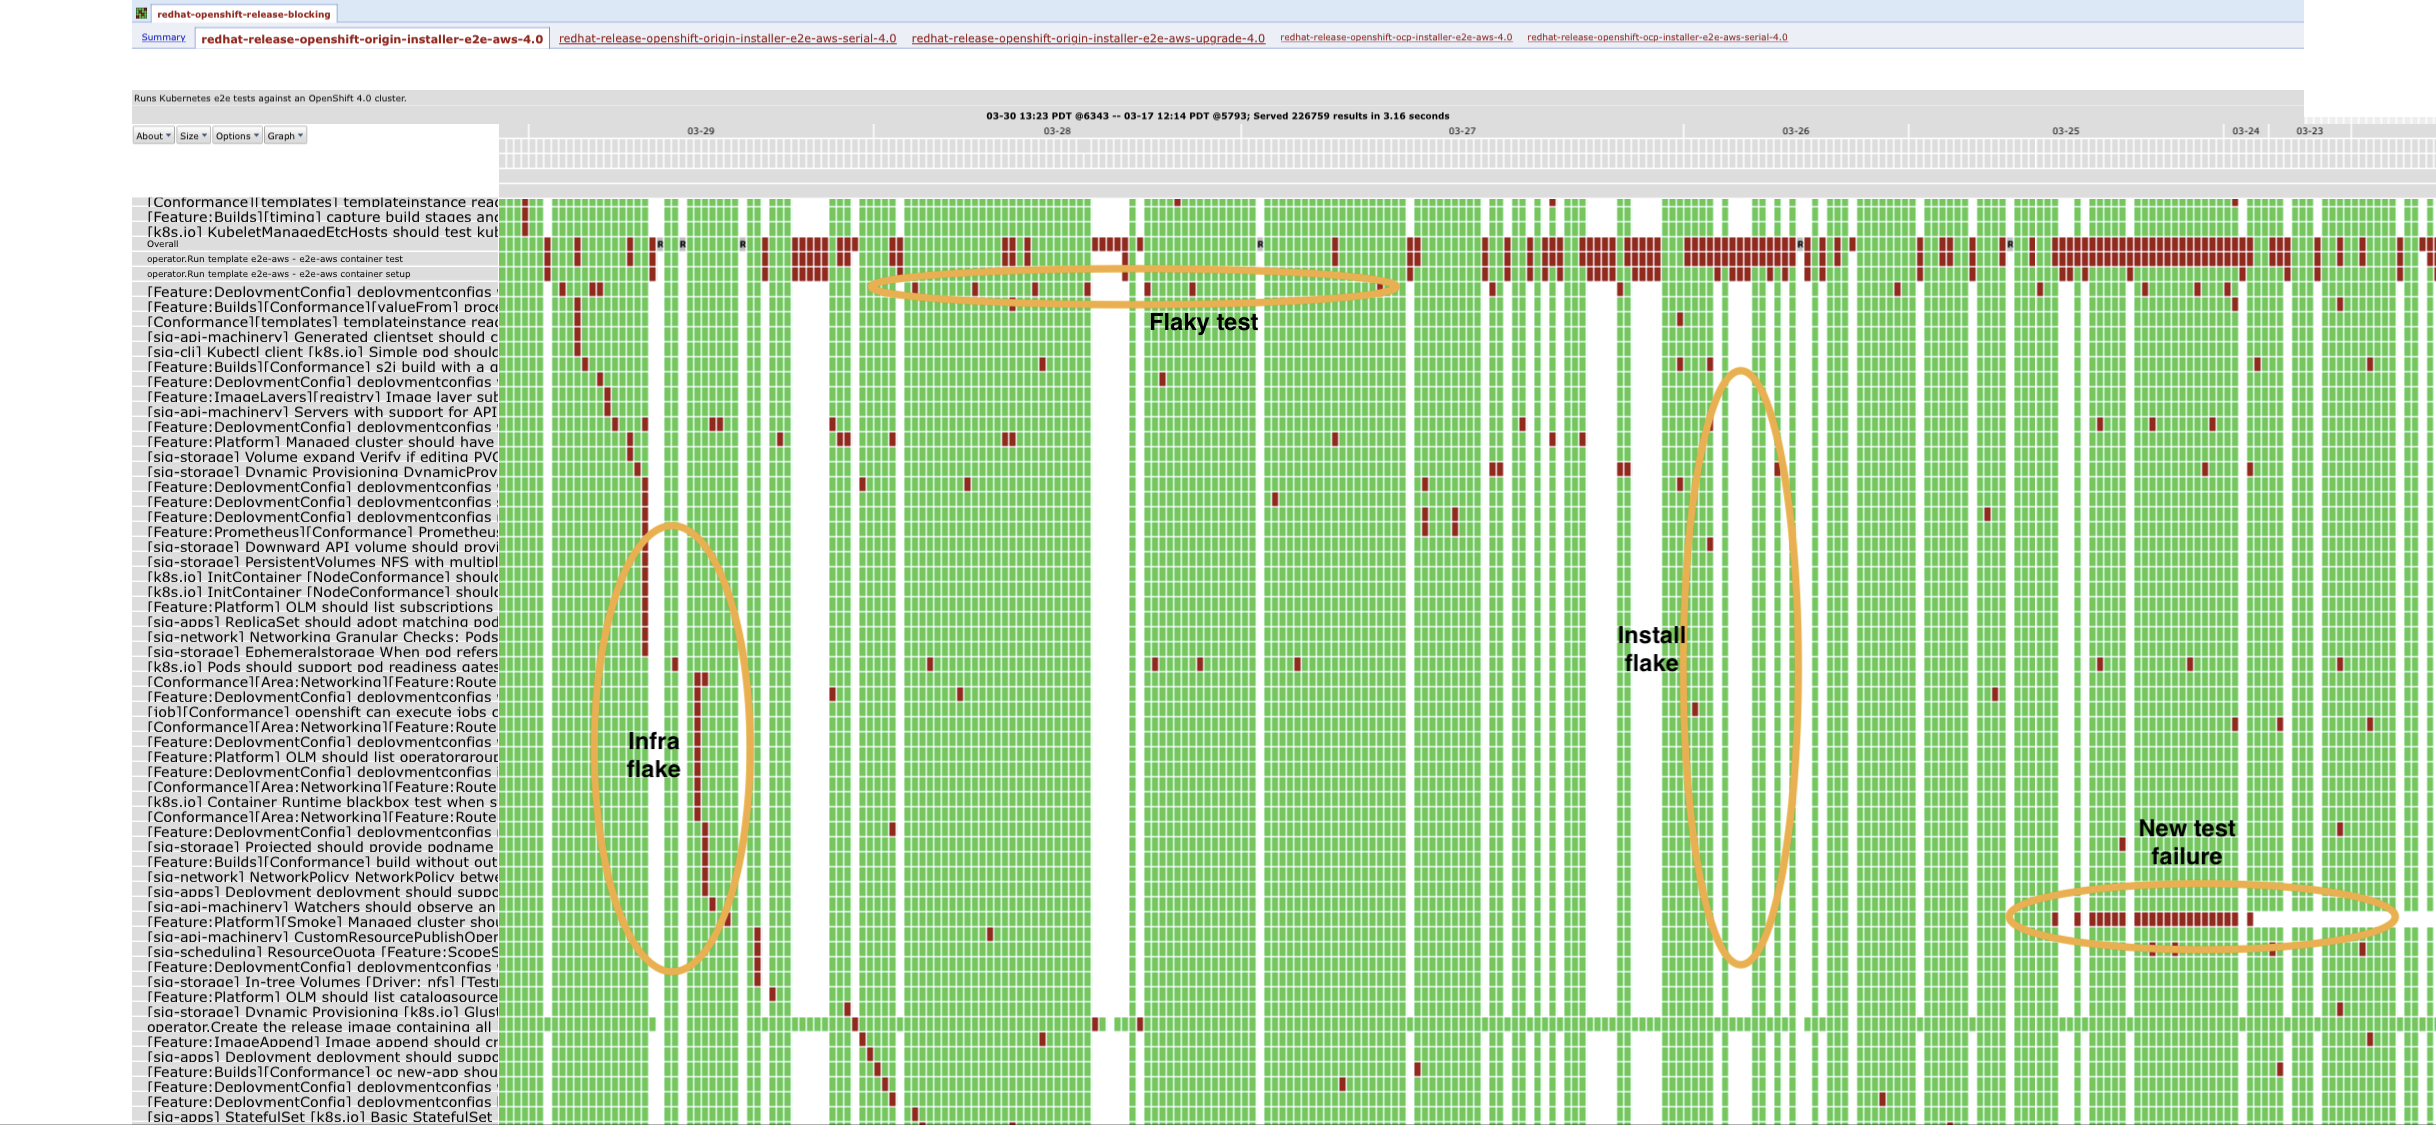

In [4]:
Image(
    "https://user-images.githubusercontent.com/161888/89903201-a62b3800-dbe7-11ea-9b1c-2ec62fe8952f.png"
)

### Hand annotated example

The image above is a hand annotated testgrid. The aim of this notebook is to automate this process. 

In [5]:
def run_length_encode(x):
    """run length encoding """

    rle = []
    count = 1
    for i, j in enumerate(x):
        key = j
        if i == len(x) - 1:
            rle.append((key, count, i))
            break
        if key == x[i + 1]:
            count += 1
        else:
            rle.append((key, count, i))
            count = 1
    return rle

In [6]:
# load sample data
with gzip.open("../../../data/raw/testgrid_810.json.gz", "rb") as read_file:
    data = json.load(read_file)

In [7]:
grid = data['"redhat-openshift-ocp-release-4.3-informing"'][
    "release-openshift-origin-installer-e2e-gcp-compact-4.3"
]["grid"]

In [8]:
# use the decode_run_length function imported from TestGrid_EDA notebook
x = np.array(list(pd.DataFrame(grid).statuses.apply(decode_run_length)))

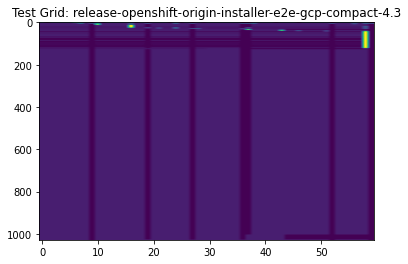

In [9]:
# Display example testgrid
plt.imshow(x, aspect="auto")
plt.title("Test Grid: release-openshift-origin-installer-e2e-gcp-compact-4.3")
plt.show()

In [10]:
# We want to re-map the values so that the output of the convolution will be more interpretable.
def normalize(x):
    if x == 1:
        return 1
    if x == 12:
        return -1
    if x == 0:
        return 0

### Detect Infrastructure Flakes

In [11]:
def detect_infra_flake(grid, tab_name, grid_name):
    """
    This function takes a 2d numpy array "grid" and uses a diagonal edge detecting
    filter to identify time windows in which 'infrastructure flakes' occured.

    Returns a list of dates and test indexes
    """
    infra_flakes_found = []

    # 2d filter that will have its highest value when convolved with a diagonal pattern.
    infra_flake_filter = np.array([[-1, 1], [1, -1]])

    # Find the spots on the map where the convolution had its maximum value.
    spots = convolve2d(infra_flake_filter, x, mode="valid")
    infra_flakes = np.where(spots == 4)

    dates = data[tab_name][grid_name]["timestamps"]
    infra_flake_dates = np.array(dates)[list([infra_flakes][0][1])]
    infra_flake_dates = [
        datetime.date.fromtimestamp(x // 1000) for x in infra_flake_dates
    ]

    infra_flake_tests = list([infra_flakes][0][0])

    infra_flakes_found = list(zip(infra_flake_dates, infra_flake_tests))

    return infra_flakes_found

In [12]:
x = pd.DataFrame(x).apply(lambda x: [normalize(y) for y in x])

In [13]:
x = np.array(x)
detect_infra_flake(
    x,
    '"redhat-openshift-ocp-release-4.3-informing"',
    "release-openshift-origin-installer-e2e-gcp-compact-4.3",
)

[(datetime.date(2020, 10, 2), 1), (datetime.date(2020, 10, 1), 3)]

### Detect Install Flakes

In [14]:
def detect_install_flake(grid, tab_name, grid_name):
    """
    If greater than 90% of tests are not run for 2 or more consecutive days,
    then we will record this period as as an install flake.
    """
    install_flakes = []

    n_rows, n_cols = grid.shape
    grid = pd.DataFrame(grid)
    not_run_percent = grid.apply(lambda x: sum(x == 0) / n_rows, axis=0)
    install_errors = not_run_percent > 0.90
    install_error_streaks = run_length_encode(install_errors)

    for i in install_error_streaks:
        if i[0] is True and i[1] >= 2:
            install_flakes.append((i[2] - i[1], i[2]))

    dates = data[tab_name][grid_name]["timestamps"]
    install_flake_dates = np.array(dates)[list([install_flakes][0][0])]
    install_flake_dates = [
        datetime.date.fromtimestamp(x // 1000) for x in install_flake_dates
    ]

    return install_flake_dates

In [15]:
detect_install_flake(
    x,
    '"redhat-openshift-ocp-release-4.3-informing"',
    "release-openshift-origin-installer-e2e-gcp-compact-4.3",
)

[datetime.date(2020, 9, 2), datetime.date(2020, 8, 31)]

## Detect New Test Failures 

In [16]:
def detect_new_test_failures(grid, tab_name, grid_name):
    """
    If 6 or more consecutive failures occur, then we will record this period
    as a new test failure
    """
    grid = pd.DataFrame(grid)
    new_test_failures = grid.apply(single_new_test_failure, axis=1)
    none_empties = new_test_failures[
        new_test_failures.apply(lambda x: len(x)) > 0
    ]

    dates = data[tab_name][grid_name]["timestamps"]

    for i, j in enumerate(none_empties):
        none_empties[i] = [np.array(dates)[[x[0], x[1]]] for x in j]

        none_empties[i] = [
            (
                datetime.date.fromtimestamp(x[0] // 1000),
                datetime.date.fromtimestamp(x[1] // 1000),
            )
            for x in none_empties[i]
        ]

    idx = list(none_empties.index)
    new_test_failures = [
        (idx[i], none_empties[i]) for i in range(len(none_empties))
    ]

    return new_test_failures


def single_new_test_failure(test):

    """given a test as an array of values, uses run length encoding to
    find occurences of 6 or moe consecutive failures for a test."""

    new_test_failure = []
    rle = run_length_encode(test)

    #     if rle[-1][0] == 0 and rle[-2][0] == -1 and rle[-2][1] >= 6:
    #         new_test_failure.append((rle[-2][2]-rle[-2][1],rle[-2][2]))

    if rle[-1][0] == 0 and rle[-2][0] == -1:

        for i, j in reversed(list(enumerate(rle[:-2]))):
            if j[0] == 1:
                break

        end_of_grid = rle[i:]

        count = 0
        for streak in end_of_grid:
            if streak[0] == -1:
                count += streak[1]

        if count >= 6:
            new_test_failure.append((end_of_grid[0][2], end_of_grid[-1][2]))

    return new_test_failure

In [17]:
detect_new_test_failures(
    x,
    '"redhat-openshift-ocp-release-4.3-informing"',
    "release-openshift-origin-installer-e2e-gcp-compact-4.3",
)

[(0, [(datetime.date(2020, 10, 7), datetime.date(2020, 8, 9))])]

## Detect Flaky Tests

In [18]:
def detect_flaky_test(grid, tab_name, grid_name):
    """
    Apply run calc_optimal_flakiness_score to out grid
    """

    flaky_tests = []
    dates = data[tab_name][grid_name]["timestamps"]
    for i, j in enumerate(grid):

        # use the calc_optimal_flakiness_score function imported from testgrid_flakiness_detection notebook
        found_flakes = calc_optimal_flakiness_score(grid[i])
        if len(found_flakes[1].keys()) > 0:
            times = [
                np.array(dates)[[x[0], x[1]]] for x in found_flakes[1].keys()
            ]
            times = [
                (
                    datetime.date.fromtimestamp(x[0] // 1000),
                    datetime.date.fromtimestamp(x[1] // 1000),
                )
                for x in times
            ]

            flaky_tests.append((i, found_flakes[1], times))

    return flaky_tests

In [19]:
detect_flaky_test(
    x,
    '"redhat-openshift-ocp-release-4.3-informing"',
    "release-openshift-origin-installer-e2e-gcp-compact-4.3",
)

[]

## Failure Type Identification 

Bring all 4 methods together to identify the different failure types for a single testgrid and generate a report.

In [20]:
grid = data['"redhat-openshift-ocp-release-4.3-informing"'][
    "release-openshift-origin-installer-e2e-gcp-compact-4.3"
]["grid"]

In [21]:
def detect_failures(grid, tab_name, grid_name):
    """
    This takens in a grid and runs all of our detectors and outputs a report
    """

    failure_report = {}

    # use the decode_run_length function imported from TestGrid_EDA notebook
    x = np.array(list(pd.DataFrame(grid).statuses.apply(decode_run_length)))

    failure_report["flaky_tests"] = detect_flaky_test(x, tab_name, grid_name)

    x = pd.DataFrame(x).apply(lambda x: [normalize(y) for y in x])
    x = np.array(x)

    failure_report["infra_flake"] = detect_infra_flake(x, tab_name, grid_name)
    failure_report["install_flake"] = detect_install_flake(
        x, tab_name, grid_name
    )
    failure_report["new_test_failure"] = detect_new_test_failures(
        x, tab_name, grid_name
    )

    return failure_report

In [22]:
results = detect_failures(
    grid,
    '"redhat-openshift-ocp-release-4.3-informing"',
    "release-openshift-origin-installer-e2e-gcp-compact-4.3",
)

In [23]:
def print_report(results, tab_name, grid_name):
    print(
        f"Failure Report for: \n\
    {tab_name}/{grid_name}",
        end="\n\n",
    )

    print("Flaky Tests:")
    for ft in results["flaky_tests"]:
        print(f"Test number {ft[0]} had flakes at:")
        for i in ft[2]:
            print(f"{i[1]} to {i[0]}")

    print("\b")
    print(
        "Infra Flake:",
    )
    for infr in results["infra_flake"]:
        print(f"Test number {infr[1]} had an infra flake at {infr[0]}")

    print("\b")
    print("Install Flake:")
    for inst in results["install_flake"]:
        print(f"An install flake started on {inst}")

    print("\b")
    print("New Test Failures:")
    for ntf in results["new_test_failure"]:
        print(f"Test number {ntf[0]} had new test failures at:")
        for i in ntf[1]:
            print(f"{i[1]} to {i[0]}")

In [24]:
print_report(
    results,
    '"redhat-openshift-ocp-release-4.3-informing"',
    "release-openshift-origin-installer-e2e-gcp-compact-4.3",
)

Failure Report for: 
    "redhat-openshift-ocp-release-4.3-informing"/release-openshift-origin-installer-e2e-gcp-compact-4.3

Flaky Tests:
Test number 6 had flakes at:
2020-09-18 to 2020-09-22
2020-09-10 to 2020-09-14

Infra Flake:
Test number 1 had an infra flake at 2020-10-02
Test number 3 had an infra flake at 2020-10-01

Install Flake:
An install flake started on 2020-09-02
An install flake started on 2020-08-31

New Test Failures:
Test number 0 had new test failures at:
2020-08-09 to 2020-10-07


We can now take a single test grid and identify the tests and dates where different error types occurred using the 4 heuristic based methods above.

Next, we will use this report to annotate the grids themselves. And finally we will apply this to the entire testgrid dataset to generate some aggregated metrics about this failure types.